In [49]:
from collections import OrderedDict

In [50]:
from torch import nn
from torchvision.models.utils import load_state_dict_from_url
import torch.nn.functional as F

__all__ = ['MobileNetV2', 'mobilenet_v2']


model_urls = {
    'mobilenet_v2': 'https://download.pytorch.org/models/mobilenet_v2-b0353104.pth',
}


def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class ConvBNReLU(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, dilation=1, groups=1):
        #padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, 0, dilation=dilation, groups=groups, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.ReLU6(inplace=True)
        )

def fixed_padding(kernel_size, dilation):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (dilation - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    return (pad_beg, pad_end, pad_beg, pad_end) 

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, dilation, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            # pw
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1))

        layers.extend([
            # dw
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, dilation=dilation, groups=hidden_dim),
            # pw-linear
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        ])
        self.conv = nn.Sequential(*layers)

        self.input_padding = fixed_padding( 3, dilation )

    def forward(self, x):
        x_pad = F.pad(x, self.input_padding)
        if self.use_res_connect:
            return x + self.conv(x_pad)
        else:
            return self.conv(x_pad)

class MobileNetV2(nn.Module):
    def __init__(self, num_classes=1000, output_stride=8, width_mult=1.0, inverted_residual_setting=None, round_nearest=8):
        """
        MobileNet V2 main class

        Args:
            num_classes (int): Number of classes
            width_mult (float): Width multiplier - adjusts number of channels in each layer by this amount
            inverted_residual_setting: Network structure
            round_nearest (int): Round the number of channels in each layer to be a multiple of this number
            Set to 1 to turn off rounding
        """
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        self.output_stride = output_stride
        current_stride = 1
        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError("inverted_residual_setting should be non-empty "
                             "or a 4-element list, got {}".format(inverted_residual_setting))

        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features = [ConvBNReLU(3, input_channel, stride=2)]
        current_stride *= 2
        dilation=1
        previous_dilation = 1

        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            previous_dilation = dilation
            if current_stride == output_stride:
                stride = 1
                dilation *= s
            else:
                stride = s
                current_stride *= s
            output_channel = int(c * width_mult)

            for i in range(n):
                if i==0:
                    features.append(block(input_channel, output_channel, stride, previous_dilation, expand_ratio=t))
                else:
                    features.append(block(input_channel, output_channel, 1, dilation, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1))
        # make it nn.Sequential
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])
        x = self.classifier(x)
        return x


def mobilenet_v2(pretrained=False, progress=True, **kwargs):
    """
    Constructs a MobileNetV2 architecture from
    `"MobileNetV2: Inverted Residuals and Linear Bottlenecks" <https://arxiv.org/abs/1801.04381>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = MobileNetV2(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['mobilenet_v2'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [51]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from collections import OrderedDict

class _SimpleSegmentationModel(nn.Module):
    def __init__(self, backbone, classifier):
        super(_SimpleSegmentationModel, self).__init__()
        self.backbone = backbone
        self.classifier = classifier
        
    def forward(self, x):
        input_shape = x.shape[-2:]
        print()
        features = self.backbone(x)
        x = self.classifier(features)
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        return x


class IntermediateLayerGetter(nn.ModuleDict):
    """
    Module wrapper that returns intermediate layers from a model

    It has a strong assumption that the modules have been registered
    into the model in the same order as they are used.
    This means that one should **not** reuse the same nn.Module
    twice in the forward if you want this to work.

    Additionally, it is only able to query submodules that are directly
    assigned to the model. So if `model` is passed, `model.feature1` can
    be returned, but not `model.feature1.layer2`.

    Arguments:
        model (nn.Module): model on which we will extract the features
        return_layers (Dict[name, new_name]): a dict containing the names
            of the modules for which the activations will be returned as
            the key of the dict, and the value of the dict is the name
            of the returned activation (which the user can specify).

    Examples::

        >>> m = torchvision.models.resnet18(pretrained=True)
        >>> # extract layer1 and layer3, giving as names `feat1` and feat2`
        >>> new_m = torchvision.models._utils.IntermediateLayerGetter(m,
        >>>     {'layer1': 'feat1', 'layer3': 'feat2'})
        >>> out = new_m(torch.rand(1, 3, 224, 224))
        >>> print([(k, v.shape) for k, v in out.items()])
        >>>     [('feat1', torch.Size([1, 64, 56, 56])),
        >>>      ('feat2', torch.Size([1, 256, 14, 14]))]
    """
    def __init__(self, model, return_layers):
        if not set(return_layers).issubset([name for name, _ in model.named_children()]):
            raise ValueError("return_layers are not present in model")

        orig_return_layers = return_layers
        return_layers = {k: v for k, v in return_layers.items()}
        layers = OrderedDict()
        for name, module in model.named_children():
            layers[name] = module
            if name in return_layers:
                del return_layers[name]
            if not return_layers:
                break

        super(IntermediateLayerGetter, self).__init__(layers)
        self.return_layers = orig_return_layers

    def forward(self, x):
        out = OrderedDict()
        for name, module in self.named_children():
            x = module(x)
            if name in self.return_layers:
                out_name = self.return_layers[name]
                out[out_name] = x
        return out

In [52]:
import torch
from torch import nn
from torch.nn import functional as F

#from .utils import _SimpleSegmentationModel


__all__ = ["DeepLabV3"]


class DeepLabV3(_SimpleSegmentationModel):
    """
    Implements DeepLabV3 model from
    `"Rethinking Atrous Convolution for Semantic Image Segmentation"
    <https://arxiv.org/abs/1706.05587>`_.

    Arguments:
        backbone (nn.Module): the network used to compute the features for the model.
            The backbone should return an OrderedDict[Tensor], with the key being
            "out" for the last feature map used, and "aux" if an auxiliary classifier
            is used.
        classifier (nn.Module): module that takes the "out" element returned from
            the backbone and returns a dense prediction.
        aux_classifier (nn.Module, optional): auxiliary classifier used during training
    """
    pass

class DeepLabHeadV3Plus(nn.Module):
    def __init__(self, in_channels, low_level_channels, num_classes, aspp_dilate=[12, 24, 36]):
        super(DeepLabHeadV3Plus, self).__init__()
        self.project = nn.Sequential( 
            nn.Conv2d(low_level_channels, 48, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),
        )

        self.aspp = ASPP(in_channels, aspp_dilate)
#수정 사항 reverse separable conv
        self.classifier = nn.Sequential(
            # PointWise Conv            
            nn.Conv2d( in_channels=304, out_channels=256, kernel_size=1, stride=1, padding=0, bias=False), 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),            
            # Separable Conv            
            nn.Conv2d( in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0, dilation=1, bias=False, groups=256 ),


            nn.Conv2d(256, num_classes, 1)
        )
        self._init_weight()

    def forward(self, feature):
        low_level_feature = self.project( feature['low_level'] )
        output_feature = self.aspp(feature['out'])
        output_feature = F.interpolate(output_feature, size=low_level_feature.shape[2:], mode='bilinear', align_corners=False)
        return self.classifier( torch.cat( [ low_level_feature, output_feature ], dim=1 ) )
    
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

class DeepLabHead(nn.Module):
    def __init__(self, in_channels, num_classes, aspp_dilate=[12, 24, 36]):
        super(DeepLabHead, self).__init__()

        self.classifier = nn.Sequential(
            ASPP(in_channels, aspp_dilate),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes, 1)
        )
        self._init_weight()

    def forward(self, feature):
        return self.classifier( feature['out'] )

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

class AtrousSeparableConvolution(nn.Module):
    """ Atrous Separable Convolution
    """
    def __init__(self, in_channels, out_channels, kernel_size,
                            stride=1, padding=0, dilation=1, bias=True):
        super(AtrousSeparableConvolution, self).__init__()
        self.body = nn.Sequential(
            # Separable Conv
            nn.Conv2d( in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias, groups=in_channels ),
            # PointWise Conv
            nn.Conv2d( in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=bias),
        )
        
        self._init_weight()

    def forward(self, x):
        return self.body(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        super(ASPPConv, self).__init__(*modules)

class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(ASPPPooling, self).__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))

    def forward(self, x):
        size = x.shape[-2:]
        x = super(ASPPPooling, self).forward(x)
        return F.interpolate(x, size=size, mode='bilinear', align_corners=False)
## rate 추가, 모듈 어펜드 추가, 5->6
class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates):
        super(ASPP, self).__init__()
        out_channels = 256
        modules = []
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)))

        rate1, rate2, rate3, rate4 = tuple(atrous_rates)
        modules.append(ASPPConv(in_channels, out_channels, rate1))
        modules.append(ASPPConv(in_channels, out_channels, rate2))
        modules.append(ASPPConv(in_channels, out_channels, rate3))
        modules.append(ASPPConv(in_channels, out_channels, rate4))        
        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            nn.Conv2d(6 * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),)

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)



def convert_to_separable_conv(module):
    new_module = module
    if isinstance(module, nn.Conv2d) and module.kernel_size[0]>1 and module.in_channels == 320 :
        print('nn.Conv2d : ', nn.Conv2d)
        #print('nn.Conv2d[0] : ', nn.Conv2d[0])
        print('module.in_channels : ', module.in_channels)
        #print('module.in_channels[0] : ', module.in_channels[0])
        new_module = AtrousSeparableConvolution(module.in_channels,
                                      module.out_channels, 
                                      module.kernel_size,
                                      module.stride,
                                      module.padding,
                                      module.dilation,
                                      module.bias)
    for name, child in module.named_children():
        new_module.add_module(name, convert_to_separable_conv(child))
    return new_module

In [53]:
#    from .utils import IntermediateLayerGetter
#    from ._deeplab import DeepLabHead, DeepLabHeadV3Plus, DeepLabV3
#    from .backbone import resnet
#    from .backbone import mobilenetv2

def _segm_resnet(name, backbone_name, num_classes, output_stride, pretrained_backbone):

    if output_stride==8:
        replace_stride_with_dilation=[False, True, True]
        aspp_dilate = [12, 24, 36]
    else:
        replace_stride_with_dilation=[False, False, True]
        aspp_dilate = [6, 12, 18, 24]

    backbone = resnet.__dict__[backbone_name](
        pretrained=pretrained_backbone,
        replace_stride_with_dilation=replace_stride_with_dilation)
    
    inplanes = 2048
    low_level_planes = 256

    if name=='deeplabv3plus':
        return_layers = {'layer4': 'out', 'layer1': 'low_level'}
        classifier = DeepLabHeadV3Plus(inplanes, low_level_planes, num_classes, aspp_dilate)
    elif name=='deeplabv3':
        return_layers = {'layer4': 'out'}
        classifier = DeepLabHead(inplanes , num_classes, aspp_dilate)
    backbone = IntermediateLayerGetter(backbone, return_layers=return_layers)

    model = DeepLabV3(backbone, classifier)
    return model
##여기 추가
def _segm_mobilenet(name, backbone_name, num_classes, output_stride, pretrained_backbone):
    if output_stride==8:
        aspp_dilate = [12, 24, 36]
    else:
        aspp_dilate = [6, 12, 18, 24]

    backbone = mobilenet_v2(pretrained=pretrained_backbone, output_stride=output_stride)
    
    # rename layers
    backbone.low_level_features = backbone.features[0:4]
    backbone.high_level_features = backbone.features[4:-1]
    backbone.features = None
    backbone.classifier = None

    inplanes = 320
    low_level_planes = 24
    
    if name=='deeplabv3plus':
        return_layers = {'high_level_features': 'out', 'low_level_features': 'low_level'}
        classifier = DeepLabHeadV3Plus(inplanes, low_level_planes, num_classes, aspp_dilate)
    elif name=='deeplabv3':
        return_layers = {'high_level_features': 'out'}
        classifier = DeepLabHead(inplanes , num_classes, aspp_dilate)
    backbone = IntermediateLayerGetter(backbone, return_layers=return_layers)

    model = DeepLabV3(backbone, classifier)
    return model

def _load_model(arch_type, backbone, num_classes, output_stride, pretrained_backbone):

    if backbone=='mobilenetv2':
        model = _segm_mobilenet(arch_type, backbone, num_classes, output_stride=output_stride, pretrained_backbone=pretrained_backbone)
    elif backbone.startswith('resnet'):
        model = _segm_resnet(arch_type, backbone, num_classes, output_stride=output_stride, pretrained_backbone=pretrained_backbone)
    else:
        raise NotImplementedError
    return model


# Deeplab v3

def deeplabv3_resnet50(num_classes=21, output_stride=8, pretrained_backbone=True):
    """Constructs a DeepLabV3 model with a ResNet-50 backbone.

    Args:
        num_classes (int): number of classes.
        output_stride (int): output stride for deeplab.
        pretrained_backbone (bool): If True, use the pretrained backbone.
    """
    return _load_model('deeplabv3', 'resnet50', num_classes, output_stride=output_stride, pretrained_backbone=pretrained_backbone)

def deeplabv3_resnet101(num_classes=21, output_stride=8, pretrained_backbone=True):
    """Constructs a DeepLabV3 model with a ResNet-101 backbone.

    Args:
        num_classes (int): number of classes.
        output_stride (int): output stride for deeplab.
        pretrained_backbone (bool): If True, use the pretrained backbone.
    """
    return _load_model('deeplabv3', 'resnet101', num_classes, output_stride=output_stride, pretrained_backbone=pretrained_backbone)

def deeplabv3_mobilenet(num_classes=21, output_stride=8, pretrained_backbone=True, **kwargs):
    """Constructs a DeepLabV3 model with a MobileNetv2 backbone.

    Args:
        num_classes (int): number of classes.
        output_stride (int): output stride for deeplab.
        pretrained_backbone (bool): If True, use the pretrained backbone.
    """
    return _load_model('deeplabv3', 'mobilenetv2', num_classes, output_stride=output_stride, pretrained_backbone=pretrained_backbone)


# Deeplab v3+

def deeplabv3plus_resnet50(num_classes=21, output_stride=8, pretrained_backbone=True):
    """Constructs a DeepLabV3 model with a ResNet-50 backbone.

    Args:
        num_classes (int): number of classes.
        output_stride (int): output stride for deeplab.
        pretrained_backbone (bool): If True, use the pretrained backbone.
    """
    return _load_model('deeplabv3plus', 'resnet50', num_classes, output_stride=output_stride, pretrained_backbone=pretrained_backbone)


def deeplabv3plus_resnet101(num_classes=21, output_stride=8, pretrained_backbone=True):
    """Constructs a DeepLabV3+ model with a ResNet-101 backbone.

    Args:
        num_classes (int): number of classes.
        output_stride (int): output stride for deeplab.
        pretrained_backbone (bool): If True, use the pretrained backbone.
    """
    return _load_model('deeplabv3plus', 'resnet101', num_classes, output_stride=output_stride, pretrained_backbone=pretrained_backbone)


def deeplabv3plus_mobilenet(num_classes=21, output_stride=16, pretrained_backbone=True):
    """Constructs a DeepLabV3+ model with a MobileNetv2 backbone.

    Args:
        num_classes (int): number of classes.
        output_stride (int): output stride for deeplab.
        pretrained_backbone (bool): If True, use the pretrained backbone.
    """
    return _load_model('deeplabv3plus', 'mobilenetv2', num_classes, output_stride=output_stride, pretrained_backbone=pretrained_backbone)

In [54]:
#import argparse

In [55]:
#CKPT_PATH ="/home/aiffel-dj54/aiffel/siaiffel/DeepLabV3Plus-Pytorch-master/checkpoints/best_deeplabv3plus_mobilenet_satellites_multi_os16.pth"

In [56]:
#import network
model_map = {
        'deeplabv3_resnet50': deeplabv3_resnet50,
        'deeplabv3plus_resnet50': deeplabv3plus_resnet50,
        'deeplabv3_resnet101': deeplabv3_resnet101,
        'deeplabv3plus_resnet101': deeplabv3plus_resnet101,
        'deeplabv3_mobilenet': deeplabv3_mobilenet,
        'deeplabv3plus_mobilenet': deeplabv3plus_mobilenet
    }

In [57]:
model_1 = model_map['deeplabv3plus_mobilenet'](num_classes=3, output_stride=16)
convert_to_separable_conv(model_1.classifier)
#model.load_state_dict(checkpoint["model_state"])

nn.Conv2d :  <class 'torch.nn.modules.conv.Conv2d'>
module.in_channels :  320
nn.Conv2d :  <class 'torch.nn.modules.conv.Conv2d'>
module.in_channels :  320
nn.Conv2d :  <class 'torch.nn.modules.conv.Conv2d'>
module.in_channels :  320
nn.Conv2d :  <class 'torch.nn.modules.conv.Conv2d'>
module.in_channels :  320


DeepLabHeadV3Plus(
  (project): Sequential(
    (0): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (aspp): ASPP(
    (convs): ModuleList(
      (0): Sequential(
        (0): Conv2d(320, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): ASPPConv(
        (0): AtrousSeparableConvolution(
          (body): Sequential(
            (0): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6), groups=320, bias=False)
            (1): Conv2d(320, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (2): ASPPConv(
        (0): 

In [58]:
model_1.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (low_level_features): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        

In [11]:
from torch.utils.tensorboard import SummaryWriter
log_dir = "./runs/new_one"
writer = SummaryWriter(log_dir)

In [12]:
import torchvision
import torch
import torchvision.transforms.functional as F
import random 
import numbers
import numpy as np
from PIL import Image


#
#  Extended Transforms for Semantic Segmentation
#
class ExtRandomHorizontalFlip(object):
    """Horizontally flip the given PIL Image randomly with a given probability.

    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL Image): Image to be flipped.

        Returns:
            PIL Image: Randomly flipped image.
        """
        if random.random() < self.p:
            return F.hflip(img), F.hflip(lbl)
        return img, lbl

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)



class ExtCompose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, lbl):
        for t in self.transforms:
            img, lbl = t(img, lbl)
        return img, lbl

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string


class ExtCenterCrop(object):
    """Crops the given PIL Image at the center.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
    """

    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL Image): Image to be cropped.
        Returns:
            PIL Image: Cropped image.
        """
        return F.center_crop(img, self.size), F.center_crop(lbl, self.size)

    def __repr__(self):
        return self.__class__.__name__ + '(size={0})'.format(self.size)


class ExtRandomScale(object):
    def __init__(self, scale_range, interpolation=Image.BILINEAR):
        self.scale_range = scale_range
        self.interpolation = interpolation

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL Image): Image to be scaled.
            lbl (PIL Image): Label to be scaled.
        Returns:
            PIL Image: Rescaled image.
            PIL Image: Rescaled label.
        """
        assert img.size == lbl.size
        scale = random.uniform(self.scale_range[0], self.scale_range[1])
        target_size = ( int(img.size[1]*scale), int(img.size[0]*scale) )
        return F.resize(img, target_size, self.interpolation), F.resize(lbl, target_size, Image.NEAREST)

    def __repr__(self):
        interpolate_str = _pil_interpolation_to_str[self.interpolation]
        return self.__class__.__name__ + '(size={0}, interpolation={1})'.format(self.size, interpolate_str)

class ExtScale(object):
    """Resize the input PIL Image to the given scale.
    Args:
        Scale (sequence or int): scale factors
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``
    """

    def __init__(self, scale, interpolation=Image.BILINEAR):
        self.scale = scale
        self.interpolation = interpolation

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL Image): Image to be scaled.
            lbl (PIL Image): Label to be scaled.
        Returns:
            PIL Image: Rescaled image.
            PIL Image: Rescaled label.
        """
        assert img.size == lbl.size
        target_size = ( int(img.size[1]*self.scale), int(img.size[0]*self.scale) ) # (H, W)
        return F.resize(img, target_size, self.interpolation), F.resize(lbl, target_size, Image.NEAREST)

    def __repr__(self):
        interpolate_str = _pil_interpolation_to_str[self.interpolation]
        return self.__class__.__name__ + '(size={0}, interpolation={1})'.format(self.size, interpolate_str)


class ExtRandomRotation(object):
    """Rotate the image by angle.
    Args:
        degrees (sequence or float or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees).
        resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
        expand (bool, optional): Optional expansion flag.
            If true, expands the output to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
        center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
    """

    def __init__(self, degrees, resample=False, expand=False, center=None):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        angle = random.uniform(degrees[0], degrees[1])

        return angle

    def __call__(self, img, lbl):
        """
            img (PIL Image): Image to be rotated.
            lbl (PIL Image): Label to be rotated.
        Returns:
            PIL Image: Rotated image.
            PIL Image: Rotated label.
        """

        angle = self.get_params(self.degrees)

        return F.rotate(img, angle, self.resample, self.expand, self.center), F.rotate(lbl, angle, self.resample, self.expand, self.center)

    def __repr__(self):
        format_string = self.__class__.__name__ + '(degrees={0}'.format(self.degrees)
        format_string += ', resample={0}'.format(self.resample)
        format_string += ', expand={0}'.format(self.expand)
        if self.center is not None:
            format_string += ', center={0}'.format(self.center)
        format_string += ')'
        return format_string

class ExtRandomHorizontalFlip(object):
    """Horizontally flip the given PIL Image randomly with a given probability.
    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL Image): Image to be flipped.
        Returns:
            PIL Image: Randomly flipped image.
        """
        if random.random() < self.p:
            return F.hflip(img), F.hflip(lbl)
        return img, lbl

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)


class ExtRandomVerticalFlip(object):
    """Vertically flip the given PIL Image randomly with a given probability.
    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL Image): Image to be flipped.
            lbl (PIL Image): Label to be flipped.
        Returns:
            PIL Image: Randomly flipped image.
            PIL Image: Randomly flipped label.
        """
        if random.random() < self.p:
            return F.vflip(img), F.vflip(lbl)
        return img, lbl

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)

class ExtPad(object):
    def __init__(self, diviser=32):
        self.diviser = diviser
    
    def __call__(self, img, lbl):
        h, w = img.size
        ph = (h//32+1)*32 - h if h%32!=0 else 0
        pw = (w//32+1)*32 - w if w%32!=0 else 0
        im = F.pad(img, ( pw//2, pw-pw//2, ph//2, ph-ph//2) )
        lbl = F.pad(lbl, ( pw//2, pw-pw//2, ph//2, ph-ph//2))
        return im, lbl

class ExtToTensor(object):
    """Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
    Converts a PIL Image or numpy.ndarray (H x W x C) in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    """
    def __init__(self, normalize=True, target_type='uint8'):
        self.normalize = normalize
        self.target_type = target_type
    def __call__(self, pic, lbl):
        """
        Note that labels will not be normalized to [0, 1].
        Args:
            pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
            lbl (PIL Image or numpy.ndarray): Label to be converted to tensor. 
        Returns:
            Tensor: Converted image and label
        """
        if self.normalize:
            return F.to_tensor(pic), torch.from_numpy( np.array( lbl, dtype=self.target_type) )
        else:
            return torch.from_numpy( np.array( pic, dtype=np.float32).transpose(2, 0, 1) ), torch.from_numpy( np.array( lbl, dtype=self.target_type) )

    def __repr__(self):
        return self.__class__.__name__ + '()'

class ExtNormalize(object):
    """Normalize a tensor image with mean and standard deviation.
    Given mean: ``(M1,...,Mn)`` and std: ``(S1,..,Sn)`` for ``n`` channels, this transform
    will normalize each channel of the input ``torch.*Tensor`` i.e.
    ``input[channel] = (input[channel] - mean[channel]) / std[channel]``
    Args:
        mean (sequence): Sequence of means for each channel.
        std (sequence): Sequence of standard deviations for each channel.
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor, lbl):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
            tensor (Tensor): Tensor of label. A dummy input for ExtCompose
        Returns:
            Tensor: Normalized Tensor image.
            Tensor: Unchanged Tensor label
        """
        return F.normalize(tensor, self.mean, self.std), lbl

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


class ExtRandomCrop(object):
    """Crop the given PIL Image at a random location.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
        padding (int or sequence, optional): Optional padding on each border
            of the image. Default is 0, i.e no padding. If a sequence of length
            4 is provided, it is used to pad left, top, right, bottom borders
            respectively.
        pad_if_needed (boolean): It will pad the image if smaller than the
            desired size to avoid raising an exception.
    """

    def __init__(self, size, padding=0, pad_if_needed=False):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding
        self.pad_if_needed = pad_if_needed

    @staticmethod
    def get_params(img, output_size):
        """Get parameters for ``crop`` for a random crop.
        Args:
            img (PIL Image): Image to be cropped.
            output_size (tuple): Expected output size of the crop.
        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for random crop.
        """
        w, h = img.size
        th, tw = output_size
        if w == tw and h == th:
            return 0, 0, h, w

        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return i, j, th, tw

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL Image): Image to be cropped.
            lbl (PIL Image): Label to be cropped.
        Returns:
            PIL Image: Cropped image.
            PIL Image: Cropped label.
        """
        assert img.size == lbl.size, 'size of img and lbl should be the same. %s, %s'%(img.size, lbl.size)
        if self.padding > 0:
            img = F.pad(img, self.padding)
            lbl = F.pad(lbl, self.padding)

        # pad the width if needed
        if self.pad_if_needed and img.size[0] < self.size[1]:
            img = F.pad(img, padding=int((1 + self.size[1] - img.size[0]) / 2))
            lbl = F.pad(lbl, padding=int((1 + self.size[1] - lbl.size[0]) / 2))

        # pad the height if needed
        if self.pad_if_needed and img.size[1] < self.size[0]:
            img = F.pad(img, padding=int((1 + self.size[0] - img.size[1]) / 2))
            lbl = F.pad(lbl, padding=int((1 + self.size[0] - lbl.size[1]) / 2))

        i, j, h, w = self.get_params(img, self.size)

        return F.crop(img, i, j, h, w), F.crop(lbl, i, j, h, w)

    def __repr__(self):
        return self.__class__.__name__ + '(size={0}, padding={1})'.format(self.size, self.padding)


class ExtResize(object):
    """Resize the input PIL Image to the given size.
    Args:
        size (sequence or int): Desired output size. If size is a sequence like
            (h, w), output size will be matched to this. If size is an int,
            smaller edge of the image will be matched to this number.
            i.e, if height > width, then image will be rescaled to
            (size * height / width, size)
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``
    """

    def __init__(self, size, interpolation=Image.BILINEAR):
        assert isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)
        self.size = size
        self.interpolation = interpolation

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL Image): Image to be scaled.
        Returns:
            PIL Image: Rescaled image.
        """
        return F.resize(img, self.size, self.interpolation), F.resize(lbl, self.size, Image.NEAREST)

    def __repr__(self):
        interpolate_str = _pil_interpolation_to_str[self.interpolation]
        return self.__class__.__name__ + '(size={0}, interpolation={1})'.format(self.size, interpolate_str) 
    
class ExtColorJitter(object):
    """Randomly change the brightness, contrast and saturation of an image.

    Args:
        brightness (float or tuple of float (min, max)): How much to jitter brightness.
            brightness_factor is chosen uniformly from [max(0, 1 - brightness), 1 + brightness]
            or the given [min, max]. Should be non negative numbers.
        contrast (float or tuple of float (min, max)): How much to jitter contrast.
            contrast_factor is chosen uniformly from [max(0, 1 - contrast), 1 + contrast]
            or the given [min, max]. Should be non negative numbers.
        saturation (float or tuple of float (min, max)): How much to jitter saturation.
            saturation_factor is chosen uniformly from [max(0, 1 - saturation), 1 + saturation]
            or the given [min, max]. Should be non negative numbers.
        hue (float or tuple of float (min, max)): How much to jitter hue.
            hue_factor is chosen uniformly from [-hue, hue] or the given [min, max].
            Should have 0<= hue <= 0.5 or -0.5 <= min <= max <= 0.5.
    """
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.brightness = self._check_input(brightness, 'brightness')
        self.contrast = self._check_input(contrast, 'contrast')
        self.saturation = self._check_input(saturation, 'saturation')
        self.hue = self._check_input(hue, 'hue', center=0, bound=(-0.5, 0.5),
                                     clip_first_on_zero=False)

    def _check_input(self, value, name, center=1, bound=(0, float('inf')), clip_first_on_zero=True):
        if isinstance(value, numbers.Number):
            if value < 0:
                raise ValueError("If {} is a single number, it must be non negative.".format(name))
            value = [center - value, center + value]
            if clip_first_on_zero:
                value[0] = max(value[0], 0)
        elif isinstance(value, (tuple, list)) and len(value) == 2:
            if not bound[0] <= value[0] <= value[1] <= bound[1]:
                raise ValueError("{} values should be between {}".format(name, bound))
        else:
            raise TypeError("{} should be a single number or a list/tuple with lenght 2.".format(name))

        # if value is 0 or (1., 1.) for brightness/contrast/saturation
        # or (0., 0.) for hue, do nothing
        if value[0] == value[1] == center:
            value = None
        return value

    @staticmethod
    def get_params(brightness, contrast, saturation, hue):
        """Get a randomized transform to be applied on image.

        Arguments are same as that of __init__.

        Returns:
            Transform which randomly adjusts brightness, contrast and
            saturation in a random order.
        """
        transforms = []

        if brightness is not None:
            brightness_factor = random.uniform(brightness[0], brightness[1])
            transforms.append(Lambda(lambda img: F.adjust_brightness(img, brightness_factor)))

        if contrast is not None:
            contrast_factor = random.uniform(contrast[0], contrast[1])
            transforms.append(Lambda(lambda img: F.adjust_contrast(img, contrast_factor)))

        if saturation is not None:
            saturation_factor = random.uniform(saturation[0], saturation[1])
            transforms.append(Lambda(lambda img: F.adjust_saturation(img, saturation_factor)))

        if hue is not None:
            hue_factor = random.uniform(hue[0], hue[1])
            transforms.append(Lambda(lambda img: F.adjust_hue(img, hue_factor)))

        random.shuffle(transforms)
        transform = Compose(transforms)

        return transform

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL Image): Input image.

        Returns:
            PIL Image: Color jittered image.
        """
        transform = self.get_params(self.brightness, self.contrast,
                                    self.saturation, self.hue)
        return transform(img), lbl

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        format_string += 'brightness={0}'.format(self.brightness)
        format_string += ', contrast={0}'.format(self.contrast)
        format_string += ', saturation={0}'.format(self.saturation)
        format_string += ', hue={0})'.format(self.hue)
        return format_string

class Lambda(object):
    """Apply a user-defined lambda as a transform.

    Args:
        lambd (function): Lambda/function to be used for transform.
    """

    def __init__(self, lambd):
        assert callable(lambd), repr(type(lambd).__name__) + " object is not callable"
        self.lambd = lambd

    def __call__(self, img):
        return self.lambd(img)

    def __repr__(self):
        return self.__class__.__name__ + '()'


class Compose(object):
    """Composes several transforms together.

    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.

    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string

In [13]:
import json
import os
from collections import namedtuple
import cv2

import torch
import torch.utils.data as data
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


class Satellites(data.Dataset):
    """Cityscapes <http://www.cityscapes-dataset.com/> Dataset.
    
    **Parameters:**
        - **root** (string): Root directory of dataset where directory 'leftImg8bit' and 'gtFine' or 'gtCoarse' are located.
        - **split** (string, optional): The image split to use, 'train', 'test' or 'val' if mode="gtFine" otherwise 'train', 'train_extra' or 'val'
        - **mode** (string, optional): The quality mode to use, 'gtFine' or 'gtCoarse' or 'color'. Can also be a list to output a tuple with all specified target types.
        - **transform** (callable, optional): A function/transform that takes in a PIL image and returns a transformed version. E.g, ``transforms.RandomCrop``
        - **target_transform** (callable, optional): A function/transform that takes in the target and transforms it.
    """

    # Based on sia
    SatellitesClass = namedtuple('SatellitesClass', ['name', 'id', 'train_id', 'category', 'category_id',
                                                     'has_instances', 'ignore_in_eval', 'color'])
    #class
    classes = [
        SatellitesClass('unlabeled',            0, 254, 'void', 0, False, True, (0, 0, 0)),
        SatellitesClass('road',                 1, 2, 'flat', 1, False, False, (128, 64, 128)),
        SatellitesClass('building',             2, 1, 'flat', 1, True, False, (70, 70, 70)),
    ]

    train_id_to_color = [c.color for c in classes if (c.train_id != -1 and c.train_id != 255)]
    train_id_to_color.append([0, 0, 0])
    train_id_to_color = np.array(train_id_to_color)
    id_to_train_id = np.array([c.train_id for c in classes])
    
    #train_id_to_color = [(0, 0, 0), (128, 64, 128), (70, 70, 70), (153, 153, 153), (107, 142, 35),
    #                      (70, 130, 180), (220, 20, 60), (0, 0, 142)]
    #train_id_to_color = np.array(train_id_to_color)
    #id_to_train_id = np.array([c.category_id for c in classes], dtype='uint8') - 1

    def __init__(self, root, split='train', mode='gtfine', target_type='sia', transform=None):
        root = '/home/aiffel-dj17/aiffel/siaiffel/DeepLabV3Plus-Pytorch-master/datasets/data/SIA/roads'
        self.root = os.path.expanduser(root)
        
        self.mode = 'gtFine'
        self.target_type = target_type
        self.images_dir = os.path.join(self.root, 'leftImg8bit', split)

        self.targets_dir = os.path.join(self.root, self.mode, split)
        self.transform = transform

        self.split = split
        self.images = []
        self.targets = []

        if split not in ['train', 'test', 'val']:
            raise ValueError('Invalid split for mode! Please use split="train", split="test"'
                             ' or split="val"')

        if not os.path.isdir(self.images_dir) or not os.path.isdir(self.targets_dir):
            raise RuntimeError('Dataset not found or incomplete. Please make sure all required folders for the'
                               ' specified "split" and "mode" are inside the "root" directory')
        
        #for city in os.listdir(self.images_dir):
            
        img_dir = os.path.join(self.images_dir)
        target_dir = os.path.join(self.targets_dir)
        
        for file_name in os.listdir(img_dir):
            self.images.append(os.path.join(img_dir, file_name))
            target_name = '{}{}'.format(file_name.split('.')[0],
                                         self._get_target_suffix(self.mode, self.target_type))
            self.targets.append(os.path.join(target_dir, target_name))

    @classmethod
    def encode_target(cls, target):
        return cls.id_to_train_id[np.array(target)]

    @classmethod
    def decode_target(cls, target):
        target[target == 255] = 1
        #target = target.astype('uint8') + 1
        return cls.train_id_to_color[target]
    
    def make_encode_target(self, target):
        target = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
        ret, dst = cv2.threshold(target, 20, 1, cv2.THRESH_BINARY)
        return dst

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is a tuple of all target types if target_type is a list with more
            than one item. Otherwise target is a json object if target_type="polygon", else the image segmentation.
        """
        image = Image.open(self.images[index]).convert('RGB')
        target = Image.open(self.targets[index])
        
        if self.transform:
            image, target = self.transform(image, target)
        target = np.array(target)
        target = self.make_encode_target(target)
        target = np.array(target, dtype='int')
        
        return image, target

    def __getimg__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is a tuple of all target types if target_type is a list with more
            than one item. Otherwise target is a json object if target_type="polygon", else the image segmentation.
        """
        image = Image.open(self.images[index]).convert('RGB')
        print(self.images[index])
        #target = Image.open(self.targets[index])
        #if self.transform:
        #    image, target = self.transform(image, target)
        #target = self.encode_target(target)
        return image #, target

    def __len__(self):
        return len(self.images)

    def _load_json(self, path):
        with open(path, 'r') as file:
            data = json.load(file)
        return data

    def _get_target_suffix(self, mode, target_type):
        if target_type == 'instance':
            return '{}_instanceIds.png'.format(mode)
        elif target_type == 'semantic':
            return '{}_labelIds.png'.format(mode)
        elif target_type == 'color':
            return '{}_color.png'.format(mode)
        elif target_type == 'polygon':
            return '{}_polygons.json'.format(mode)
        elif target_type == 'depth':
            return '{}_disparity.png'.format(mode)
        elif target_type == 'sia':
            return '.png'

In [14]:
data_root = '/home/aiffel-dj17/aiffel/siaiffel/DeepLabV3Plus-Pytorch-master/datasets/data/SIA/roads'

In [15]:
def get_dataset(opts):
    """ Dataset And Augmentation
    """
    if opts == 'cityscapes':
        train_transform = ExtCompose([
            #et.ExtResize( 512 ),
            ExtRandomCrop(size=(512, 512)),
            ExtColorJitter( brightness=0.5, contrast=0.5, saturation=0.5 ),
            ExtRandomHorizontalFlip(),
            ExtToTensor(),
            ExtNormalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
        ])

        val_transform = ExtCompose([
            #et.ExtResize( 512 ),
            ExtToTensor(),
            ExtNormalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
        ])

        train_dst = Cityscapes(root=data_root,
                               split='train', transform=train_transform)
        val_dst = Cityscapes(root=data_root,
                             split='val', transform=val_transform)
#trnasforms  
#satellites 추가 
    if opts == 'satellites':
        train_transform = ExtCompose([
            #et.ExtResize( 512 ),
            ExtRandomCrop(size=(512, 512)),
            ExtColorJitter( brightness=0.5, contrast=0.5, saturation=0.5 ),
            ExtRandomHorizontalFlip(),
            ExtToTensor(),
            ExtNormalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
        ])

        val_transform = ExtCompose([
            #et.ExtResize( 512 ),
            ExtToTensor(),
            ExtNormalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
        ])
#datasets
        train_dst = Satellites(root=data_root,
                               split='train', transform=train_transform)
        val_dst = Satellites(root=data_root,
                             split='val', transform=val_transform)
    return train_dst, val_dst



In [16]:
train_dst, val_dst = get_dataset('satellites')

train_loader = torch.utils.data.DataLoader(train_dst, batch_size=8, 
                                           shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(val_dst, batch_size=8,
                                        shuffle=False, num_workers=2)

In [17]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [18]:
# images, label = next(iter(train_loader))
# images.shape, label.shape

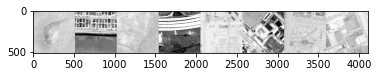

In [19]:
# 임의의 학습 이미지를 가져옵니다
# dataiter = iter(get_dataset) #여기에 추가 

images, labels = next(iter(train_loader))
images = torch.Tensor(images)
# labels = torch.Tensor(labels)

# 이미지 그리드를 만듭니다. #이미지 훈련시킬때 중간에 시각화하는 함수 
img_grid = torchvision.utils.make_grid(images) #이미지가 tensor or list

# 이미지를 보여줍니다.
matplotlib_imshow(img_grid, one_channel=True)

# tensorboard에 기록합니다. #이미지 기록 
writer.add_image('images', img_grid)

In [20]:
#모델
writer.add_graph(model_1, images)
writer.close()

AttributeError: module 'torchvision.transforms.functional' has no attribute 'interpolate'

In [21]:
print(torch.__version__)

1.8.1+cu102


In [22]:
print(tensorboard.__version__)

NameError: name 'tensorboard' is not defined

In [1]:
import tensorboard

In [2]:
print(tensorboard.__version__)

2.5.0
